<a href="https://colab.research.google.com/github/rahiakela/practical-natural-language-processing/blob/chapter-4-text-classification/11_sms_spam_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMS Spam Classification

In this notebook we demonstrate how to classify if an image is SPAM or HAM using the SMS Spam Collection Dataset which can be found [here](https://www.kaggle.com/uciml/sms-spam-collection-dataset#spam.csv).

## Setup

In [1]:
%%shell

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
unzip smsspamcollection.zip

--2020-12-10 09:01:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K  --.-KB/s    in 0.1s    

2020-12-10 09:01:55 (1.69 MB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


Setup for logistic regression classifier.

In [2]:
import numpy as np
import pandas as pd #to work with csv files

import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

from sklearn.model_selection import train_test_split

## Data Exploration

In [3]:
df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["target", "text"])
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Number of rows (instances) and columns in the dataset
display(df.shape)

# Class distribution in the dataset
df["target"].value_counts() / df.shape[0]

(5572, 2)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

In [5]:
# split data into training and validation set
df_train, df_test = train_test_split(df, stratify=df["target"], test_size=0.2, random_state=2020)
print(df_train.shape, df_test.shape)

(4457, 2) (1115, 2)


## Language model data

TextLMDataBunch applies some text preprocessing tasks to help the algorithm perform better. Altough we commonly remove stopwords and punctuations, here we do not do it. This model can handle semantics, deleting such information might do more harm than good with respect to accuracy.

In [10]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df=df_train, valid_df=df_test, path="")

# Classifier model data
data_class = TextLMDataBunch.from_df(path="", train_df=df_train, valid_df=df_test, vocab=data_lm.train_ds.vocab, bs=32)

Now lets look at our training data.

In [11]:
data_lm.show_batch()

idx,text
0,". xxmaj mark is taking forever to pick up my prescription and the pain is coming back . xxbos xxmaj your credits have been xxunk up for http : / / xxunk xxmaj your renewal xxmaj pin is xxunk xxbos xxmaj loan for any purpose £ 500 - £ 75,000 . xxmaj homeowners + xxmaj tenants welcome . xxmaj have you been previously refused ? xxmaj we can still help"
1,"b going to esplanade fr home ? xxbos somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true ... goodnite & & sweet dreams xxbos xxmaj well that must be a pain to catch xxbos sry ca n't talk on phone , with parents xxbos xxmaj hope you are having a good week . xxmaj just checking in xxbos"
2,"on a xxup reality xxup fantasy xxup show call now = 08707509020 xxmaj just 20p per min xxup ntt xxmaj ltd , xxup po xxmaj box 1327 xxmaj croydon xxup cr9 xxup 5wb 0870 is a national = rate call xxbos i think your xxunk is , but not 100 xxunk sure . xxbos xxmaj all e best 4 ur driving tmr :-) xxbos xxmaj finished class where are you"
3,"is * rite u put xxunk 10 xxunk mnth is that all ? xxbos xxmaj have you been xxunk your xxunk ? xxbos xxmaj what year . xxmaj and how many miles . xxbos , how 's things ? xxmaj just a quick question . xxbos xxmaj tell your friends what you plan to do on xxmaj valentines day @ < xxup url > xxbos * xxmaj was really good"
4,message . xxmaj this is a final contact attempt . xxmaj you have important messages waiting out our customer claims xxunk . xxmaj expires 13 / 4 / 04 . xxmaj call xxunk xxup now ! xxbos xxmaj miles and smiles r made frm same letters but do u know d difference .. ? smile on ur face keeps me happy even though i am miles away from u ..


Those 'xxmaj','xxbos', 'xxup' etc are all special tokens for the NN. xxbos stands for begin of sentence, xxmaj indicates that the first letter of the next word is in capital letter, 'xxup' is used to indicate the entire next word is in captital letters. 

You can view the entire set of tokens here.

In [12]:
model = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=0.5)

We will use a pretrained model. You can learn more about it here.

Now lets test our language model. Its is giving sensible outputs as it is pre trained on wiki corpus.

In [13]:
for i in range(10):
  print(model.predict("The food is", n_words=15))

The food is high in British food , and is often given to the people who meet
The food is too tight to hold , and it is not anywhere from one season to one
The food is not a medicine work and is not provided by Al Green .
The food is children 's works , an academic job via their English : English or
The food is but a lounge restaurant for almost a film or up - and - then -
The food is stop - hit - between - one - run and is ever run .
The food is some of the language of British travel and history , though it has not
The food is Food and Food World : Red and White Travel
The food is a Japanese drink and is used by various Japanese during the middle of
The food is sweet , and the chicken is well received as a market cake . It


In [14]:
for i in range(10):
  print(model.predict("The food is", n_words=5))

The food is in the arts and arts
The food is not always fun .
The food is taken from Chinese and
The food is used in the day to
The food is probably the largest food store
The food is sometimes common as trade or
The food is Yellow Fever =
The food is a Guy Henry
The food is other thought to help people
The food is Fat Anna ,


In [15]:
for i in range(10):
  print(model.predict("The food is", n_words=25))

The food is a doctor 's daily on the Cold Air Station . The little bonus pieces which were taken by the doctor ,
The food is by Japanese clothes table in oil pool , and is g - type and making it possible to drink a little food for hungry
The food is set off from the Old Spanish Hospital in London , but the morning is so bad that , in the following
The food is made more gudnite that way , but not all British Birds . For years , the food in the food were cheaper
The food is for nothing from Internet content , instead of coffee . It is pizza , which are foreign and trade food . It
The food is eaten in India by Indian Doctor Who Prey and Indian Royal Representative Dan Smith .
The food is collected for each Saturday morning , after an hour : by Mr. Happily . It is then available as a food
The food is enjoyed in many ends , including its base by British flag . In the middle of Cooking 's play The
The food is Spanish for " Food " . The word has been used to mark the world 's basic issues and

We will now need to fine tune our model for our particular task.

you can find more details about this at https://docs.fast.ai/basic_train.html

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 6.31E-02


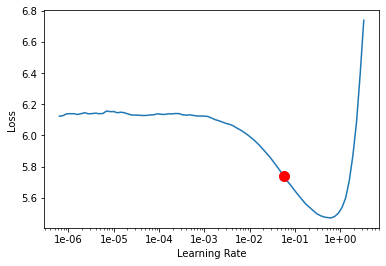

In [16]:
model.lr_find()
model.recorder.plot(suggestion=True)

you can freeze and unfreeze different layers and by doing so we can have different lr for each layer.


Please check for freezing and unfreezing code you can refer https://docs.fast.ai/text.html

In [17]:
model.fit_one_cycle(1, max_lr=5e-02)

epoch,train_loss,valid_loss,accuracy,time
0,4.990967,3.961833,0.228571,00:03


In [18]:
model.fit_one_cycle(5, max_lr=5e-02)

epoch,train_loss,valid_loss,accuracy,time
0,4.050162,3.818049,0.285714,00:03
1,3.828473,4.058096,0.257143,00:03
2,3.588484,3.910788,0.228571,00:03
3,3.310348,4.003215,0.200000,00:03
4,3.077628,3.969644,0.228571,00:03


In [19]:
for i in range(10):
  print(model.predict("The food is", n_words=15))

The food is a food food , food and food . xxbos My one of them is
The food is very potato , and take part in a dogging flirt with food Recently n
The food is very nice . The food looks like its fault , but its won a
The food is yummy and food is wife and food . i have a sweet j drive ,
The food is a slice . Its kinda kinda kinda kinda , Okie look greetings of
The food is made into a tool sound and can chip in their ideal wit their penis worries
The food is food etc . xxbos Mesages today r they awarded with Loves the £
The food is quite nice and very nice . The food needs to eat all anti sleep
The food is quite nice . You take the food from tt i d tt whatever .
The food is very big ( < # > ) . The food is very nice .


In [20]:
for i in range(10):
  print(model.predict("The food is", n_words=5))

The food is still used but food is
The food is kinda kinda kinda kinda but
The food is kinda kinda kinda and kinda
The food is very rofl . Its
The food is very nice . It
The food is quite nice . At
The food is kinda kinda kinda .
The food is kinda kinda kinda kinda kinda
The food is great . Oh .
The food is kinda pizza done or food


In [21]:
for i in range(10):
  print(model.predict("The food is", n_words=25))

The food is sexy , sexy , straight 2 ya tomo . xxbos Pete , we are doing one of New Years guaranteed !
The food is a great drink . i think of my drink and shit to collect your ass . A tea is in 10am-7pm Cost 10p
The food is quite clean : ) xxbos ü go temple & & church .. Any time time call is coming am then will b coming .
The food is natural and you have to apologise her food . You could reach online now and sell your food back from the hotel after half
The food is a food order : ) xxbos Too long then 1 / 10 2005 . T&C DAN xxbos r then u ? search
The food is no longer high . Its an food flame . Food is fair enough to vomit or its really nice for the food .
The food is from Games . They do n't know about food , and the food is slice . Its small food , confirmed for
The food is quite nice . In many few days.he have dry record players since they died but mine through the rest of our lives there .
The food is really nice . Just text me when you 're talking . Do you miss me already ? xxbos

Note that now the model is predicting ':)' and other such characters which can generally be seen in SMS messages. With further more fine tuning and running it for more cyles you can get the model to predict more characters which are found in SMS messages.